# 单因子测试示例

本示例文档展示了调用tool_kit中的回测工具进行单因子测试的过程，包括因子数据预处理、计算ICIR、计算分组回测指标、绘制分组回测净值图

## 1.工具导入

In [1]:
# 导入tool_kit中的回测工具
import warnings
from tool_kit import db_zcs, pd
from tool_kit.date_N_time import gen_trade_date, shift_date
from tool_kit.base_datastruct import basic_codes
from tool_kit.risk_module_tool import FactorCal
from tool_kit.backtest_tool import BackTest
warnings.filterwarnings('ignore')
%matplotlib inline

## 2.指定初始参数、传入因子原始数据

In [2]:
# 指定因子测试的开始时间、结束时间、换仓频率
# freq: 换仓频率，str，m月频，w周频，d日频
start_date = '2020-01-01'
end_date = '2020-12-31'
freq = 'm'
factor_date_ls = gen_trade_date(shift_date(start_date, freq, 'pre'), end_date, freq=freq)

In [3]:
# 提取因子值原始数据factor_df，pandas.DataFrame，index是(股票代码，日期)，columns是因子名称
# 日期只包含换仓日
# 原始数据可包含多个因子，每一列为一个因子，以列名区分
factor_ls = ['pe_ttm', '1m_std']
field_dict = {'_id': 0, 'code': 1, 'date': 1}
for f in factor_ls:
    field_dict[f] = 1
cursor = db_zcs.wind_financial_2014.find({'date': {'$in': factor_date_ls}, 'code': {'$in': basic_codes}}, field_dict)
factor_df = pd.DataFrame(cursor).set_index(['code', 'date'])

In [4]:
factor_df

,,pe_ttm,1m_std
code,date,,
000001.SZ,2019-12-31,11.407903,0.012357
000002.SZ,2019-12-31,9.563873,0.016783
000004.SZ,2019-12-31,-68.682877,0.024895
000005.SZ,2019-12-31,17.507517,0.013135
000006.SZ,2019-12-31,8.793908,0.010668
...,...,...,...
688981.SH,2020-12-31,119.355591,0.027148
601162.SH,2020-12-31,49.823967,0.021492
601606.SH,2020-12-31,88.599586,0.015574


## 3.数据预处理

In [5]:
# 遍历factor_df的日期标签，对因子值进行数据预处理，得到预处理后的因子暴露processed_factor_df，pandas.DataFrame，index是(股票代码，日期)，columns是因子名称
# 当factor_df中包含多个因子时，可按此demo通过一次日期标签的遍历进行多分因子的数据预处理
# 默认的数据预处理操作包括：剔除停牌股、剔除ST股、剔除新股、去极值、填空值、市值和行业中性化、标准化，如需调整可在FactorCal初始化时使用对应bool变量进行操作
# 若因子为离散变量，则不可使用当前的数据预处理操作，需自定义数据预处理过程
# 对单日空值占比超过50%的因子进行单日剔除
processed_factor_ls = []
for date in factor_date_ls:
    raw_data = factor_df.loc[(slice(None), date), :].copy()

    # 删除空值占比超过30%的因子
    nan_count = raw_data.isna().sum()
    raw_data.drop(columns=nan_count[nan_count > len(raw_data) * 0.5].index, inplace=True)
    if len(nan_count[nan_count > len(raw_data) * 0.5].index) > 0:
        print('因缺失值过多被剔除的因子: %s' % nan_count[nan_count > len(raw_data) * 0.5].index.tolist())
    raw_data.reset_index('date', inplace=True, drop=True)

    # 因子数据预处理
    fc = FactorCal(date=date, universe='A', cal_return=None, style_factor_ls=[], d_ST=True, d_suspended=True)
    fc.process_raw_factor(raw_factor_df=raw_data, style_factor_ls=factor_ls)
    processed_data = fc.process_data_df[factor_ls]
    processed_data.loc[:, 'date'] = date
    processed_data.set_index('date', append=True, inplace=True)
    processed_factor_ls.append(processed_data)
processed_factor_df = pd.concat(processed_factor_ls, axis=0, join='outer')
factor_ls = processed_factor_df.columns.tolist() # 更新因子列表，根据数据预处理结果剔除缺失值过多的因子

In [6]:
processed_factor_df

,,pe_ttm,1m_std
code,date,,
000673.SZ,2019-12-31,-0.958564,1.194716
000685.SZ,2019-12-31,-0.193802,-0.282508
000690.SZ,2019-12-31,0.629229,-0.485507
000711.SZ,2019-12-31,-1.554683,-0.441729
000715.SZ,2019-12-31,-0.318236,-0.575454
...,...,...,...
603676.SH,2020-12-31,0.922583,0.673538
601860.SH,2020-12-31,0.179389,0.666310
603871.SH,2020-12-31,-0.300342,0.618437


## 4.单因子测试

### 4.1因子pe_ttm

In [7]:
# 调用回测工具BackTest类，计算ICIR
# BackTest类各参数说明可在类注释中查阅
factor = 'pe_ttm'
factor_matrix = processed_factor_df[factor].unstack(level=1)
bt = BackTest(factor_df=factor_matrix, s_date=factor_matrix.columns.tolist()[0], e_date=end_date, freq=freq,
              universe='a_share', group=5, cal_ls_ret=True)
bt.match_price()
bt.cal_icir(rank=True)

In [8]:
bt.ic_series

2019-12-31    0.090986
2020-01-23    0.000000
2020-02-28   -0.052286
2020-03-31    0.041617
2020-04-30    0.104132
2020-05-29    0.060327
2020-06-30   -0.101865
2020-07-31   -0.093016
2020-08-31    0.000000
2020-09-30    0.000000
2020-10-30   -0.090018
2020-11-30    0.000000
2020-12-31    0.000000
dtype: float64

In [9]:
bt.ic_mean

-0.0030863283954014544

In [10]:
bt.icir

-0.04590845187063283

In [11]:
# 计算分组回测指标
bt.get_group()
bt.cal_indicator()

In [12]:
bt.indicator

,annualized_returns,max_drawdown,sharpe
group,,,
1.0,0.102778,0.166077,0.504956
2.0,0.238026,0.133024,1.017838
3.0,0.205189,0.129084,0.900386
4.0,0.254542,0.130554,0.993322
5.0,0.131416,0.146359,0.589534
long-short,0.013924,0.052188,0.466573


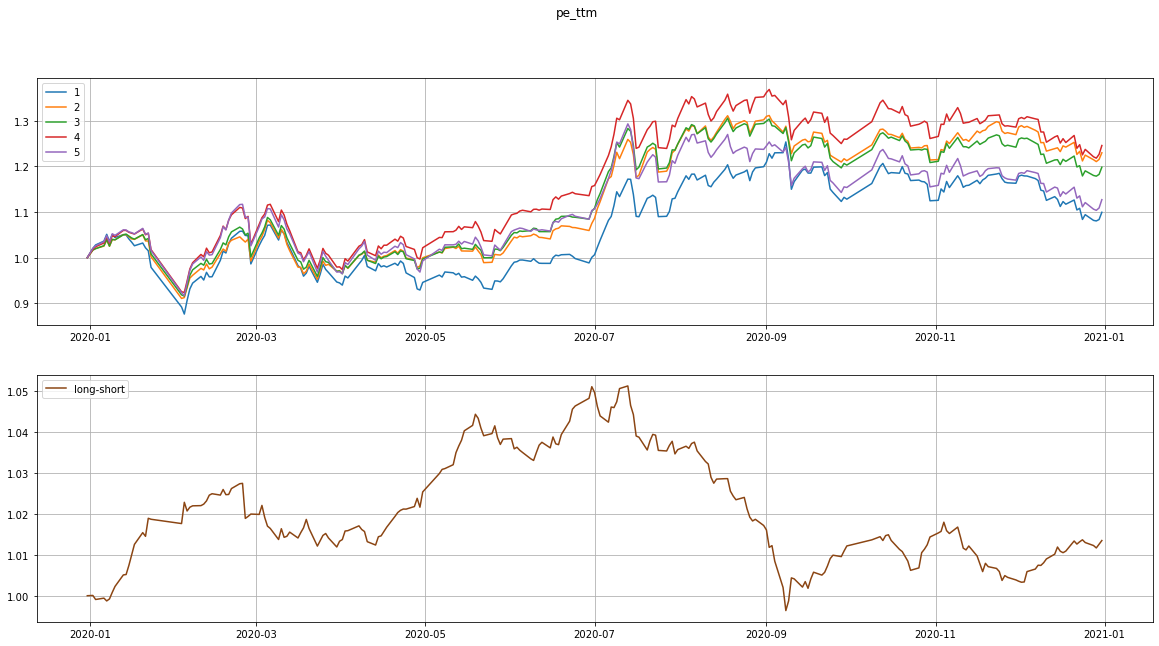

In [13]:
# 绘制分组回测净值图
# factor_name: 净值图title，str
# picture_name: 存储图片名称，str
bt.plot_value(factor_name=factor, picture_name='%s layering backtest' % factor)

### 4.2因子1m_std

In [14]:
# 调用回测工具BackTest类，计算ICIR
# BackTest类各参数说明可在类注释中查阅
factor = '1m_std'
factor_matrix = processed_factor_df[factor].unstack(level=1)
bt = BackTest(factor_df=factor_matrix, s_date=factor_matrix.columns.tolist()[0], e_date=end_date, freq=freq,
              universe='a_share', group=5, cal_ls_ret=True)
bt.match_price()
bt.cal_icir(rank=True)

In [15]:
bt.ic_series

2019-12-31    0.000000
2020-01-23    0.110897
2020-02-28   -0.324727
2020-03-31    0.000000
2020-04-30   -0.078992
2020-05-29    0.061795
2020-06-30   -0.112980
2020-07-31   -0.227377
2020-08-31   -0.086612
2020-09-30    0.106357
2020-10-30   -0.235450
2020-11-30    0.000000
2020-12-31   -0.128803
dtype: float64

In [16]:
bt.ic_mean

-0.07045326578913148

In [17]:
bt.icir

-0.5220171614999078

In [18]:
# 计算分组回测指标
bt.get_group()
bt.cal_indicator()

In [19]:
bt.indicator

,annualized_returns,max_drawdown,sharpe
group,,,
1.0,0.185456,0.145989,0.882558
2.0,0.196759,0.141930,0.876333
3.0,0.222348,0.144988,0.925411
4.0,0.223649,0.132564,0.889382
5.0,0.098083,0.192811,0.461261
long-short,-0.029265,0.108352,-0.419771


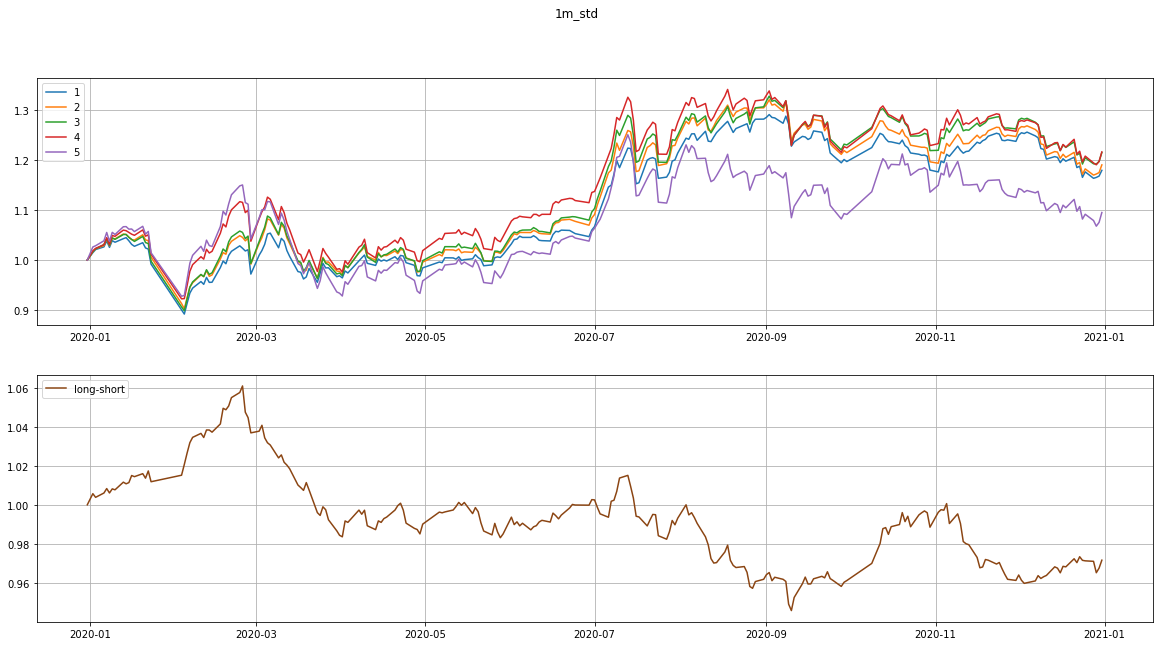

In [20]:
# 绘制分组回测净值图
# factor_name: 净值图title，str
# picture_name: 存储图片名称，str
bt.plot_value(factor_name=factor, picture_name='%s layering backtest' % factor)